[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# boston house Kernel Regression 

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 07/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0051RegressorKernel.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.datasets import fetch_openml
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotRegressionResults


In [5]:
# General Auxiliary Functions

def CosineKernel( vU: np.ndarray ) -> np.ndarray:
    return (np.abs(vU) < 1) * (1 + np.cos(np.pi * vU))

def GaussianKernel( vU: np.ndarray ) -> np.ndarray:
    return np.exp(-0.5 * np.square(vU))

def TriangularKernel( vU: np.ndarray ) -> np.ndarray:
    return (np.abs(vU) < 1) * (1 - np.abs(vU))

def UniformKernel( vU: np.ndarray ) -> np.ndarray:
    return 1 * (np.abs(vU) < 0.5)


## Kernel Regression

In this exercise we'll build an estimator with the Sci Kit Learn API.  
It will be based on the concept of Kernel Regression.

* <font color='brown'>(**#**)</font> The _Kernel Regression_ is a non parametric method. The optimization is about its _hyper parameters_.


We'll us the [Boston House Prices Dataset](https://www.openml.org/search?type=data&status=active&id=531) (See also [Kaggle - Boston House Prices](https://www.kaggle.com/datasets/vikrishnan/boston-house-prices)).  
It has 13 features and one target. 2 of the features are categorical features.

The objective is to estimate the `MDEV` of the estimation by optimizing the following hyper parameters:
 - The type of the kernel
 - The `h` parameter.

I this exercise we'll do the following:

1. Load the `Boston House Prices Dataset` data set using `fetch_openml()`.
2. Create a an estimator (Regressor) class using SciKit API:
  - Implement the constructor.
  - Implement the `fit()`, `predict()` and `score()` methods.
3. Optimize hyper parameters using _Leave One Out_ cross validation.
4. Display the output of the model.

We should get an _R2_ score above 0.75.

* <font color='brown'>(**#**)</font> In order to set the `h` parameter, one should have a look on the distance matrix of the data to get the relevant Dynamic Range of values.

In [6]:
# Parameters

lKernelType = ['Cosine', 'Gaussian', 'Triangular', 'Uniform']
#===========================Fill This===========================#
# 1. Set the range of values of `h` (Bandwidth).
lH          = list(np.linspace(0.1, 5, 40))
#===============================================================#

lKernels = [('Cosine', CosineKernel), ('Gaussian', GaussianKernel), ('Triangular', TriangularKernel), ('Uniform', UniformKernel)]

# Data Visualization
gridNoiseStd = 0.05
numGridPts = 250

## Generate / Load Data

Loading the [Boston House Prices Dataset](https://www.openml.org/search?type=data&status=active&id=531) (See also [Kaggle - Boston House Prices](https://www.kaggle.com/datasets/vikrishnan/boston-house-prices)).  
The data has 13 features and one target. 2 of the features are categorical features.


In [7]:
# Failing SSL Certificate ('[SSL: CERTIFICATE_VERIFY_FAILED')
# In case `fetch_openml()` fails with SSL Certificate issue, run this.
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
# Load Data

dfX, dsY = fetch_openml('boston', version = 1, return_X_y = True, as_frame = True, parser = 'auto')

print(f'The features data shape: {dfX.shape}')
print(f'The labels data shape: {dsY.shape}')

The features data shape: (506, 13)
The labels data shape: (506,)


In [9]:
# The Features Data
dfX.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10


In [10]:
# The Labels Data
dsY.head(10)

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
5    28.7
6    22.9
7    27.1
8    16.5
9    18.9
Name: MEDV, dtype: float64

In [11]:
# Info o the Data
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
dtypes: category(2), float64(11)
memory usage: 45.1 KB


### Plot Data

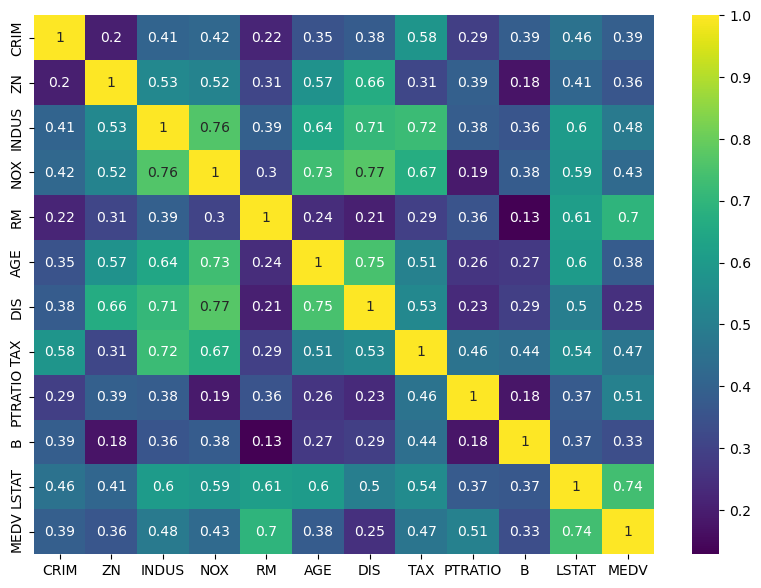

In [12]:
# Plot the Data

# We'll display the correlation matrix of the data.
# We'll add the target variable as the last variable (`MEDV`).

dfData = pd.concat([dfX, dsY], axis = 1)

hF, hA = plt.subplots(figsize = (10, 7))
sns.heatmap(dfData.corr(numeric_only = True).abs(), annot = True, cmap = 'viridis', ax = hA)

plt.show()


* <font color='red'>(**?**)</font> Would you use the above to drop some features?
* <font color='red'>(**?**)</font> Do we see all features above? How should we handle those missing?

## Training / Test Data

In [13]:
# The Training Data 

#===========================Fill This===========================#
# 1. Convert the `dfX` data frame into a matrix `mX`. Drop the categorical columns.
# 2. Convert the `dsY` data frame into a vector `vY`.
# !! You may use the `to_numpy()` method useful.
mX = dfX.drop(columns = ['CHAS', 'RAD']).to_numpy() #<! Drop the categorical data
vY = dsY.to_numpy()
#===============================================================#
print(f'type of dsY: {type(dsY)}')
print(f'type of vY: {type(vY)}')

print(f'The features data shape: {mX.shape}')
print(f'The labels data shape: {vY.shape}')

type of dsY: <class 'pandas.core.series.Series'>
type of vY: <class 'numpy.ndarray'>
The features data shape: (506, 11)
The labels data shape: (506,)


* <font color='brown'>(**#**)</font> We dropped the `CHAS` feature which is binary.  
Binary features are like _One Hot Encoding_, so we could keep it.
* <font color='red'>(**?**)</font> Why are binary features good as input while multi value categorical are not? Think about metrics.

In [14]:
# Standardizing the Data
# Since we use `h` it makes sense to keep the dynamic range fo values in tact.
# In this case we'll center the data and normalize to have a unit standard deviation.

#===========================Fill This===========================#
# 1. Construct the scaler using `StandardScaler` class.
# 2. Apply the scaler on the data.
oStdScaler = StandardScaler()
mX = oStdScaler.fit_transform(mX)
#===============================================================#

## Kernel Regressor

The kernel regression operation is defined by:

$$\boxed{\hat{f} \left( x \right) = \frac{\sum_{i = 1}^{N} w_{x} \left( {x}_{i} \right) {y}_{i}}{\sum_{i = 1}^{N} {w}_{x} \left( {x}_{i} \right)}}$$

Where ${w}_{x} \left( {x}_{i} \right) = k \left( \frac{ x - x_{i} }{ h } \right)$.

In this exercise we'll use Leave One Out validation policy with the `cross_val_predict()` function.  


### Kernel Regression Estimator

We could create the linear polynomial fit estimator using a `Pipeline` of `PolynomialFeatures` and `LinearRegression`.  
Yet since this is a simple task it is a good opportunity to exercise the creation of a _SciKit Estimator_.

We need to provide 4 main methods:

1. The `__init()__` Method: The constructor of the object. It should set the kernel type and parameter `h`.
2. The `fit()` Method: The pre processing phase. It keeps a **copy** of the fit data. It should set the `h` parameter if not set.
3. The `predict()` Method: Prediction of the values.
4. The `score()` Method: Calculates the _R2_ score.

* <font color='brown'>(**#**)</font> Make sure you read and understand the `ApplyKernelRegression()` function below.

In [15]:
# Apply Kernel Regression
# Applies the regression given a callable kernel.
# It avoids division by 0 in case no reference points are given within the kernel domain.

def ApplyKernelRegression( hKernel: Callable[np.ndarray, np.ndarray], paramH: float, mG: np.ndarray, vY: np.ndarray, mX: np.ndarray, metricType: str = 'euclidean', zeroThr: float = 1e-9 ) -> np.ndarray:

    mD = sp.spatial.distance.cdist(mX, mG, metric = metricType)  ## בomputes the distance between each point
    mW = hKernel(mD / paramH)
    vK = mW @ vY #<! For numerical stability, removing almost zero values
    vW = np.sum(mW, axis = 1)
    vI = np.abs(vW) < zeroThr #<! Calculate only when there's real data
    vK[vI] = 0
    vW[vI] = 1 #<! Remove cases of dividing by 0
    vYPred = vK / vW

    return vYPred

In [16]:
# The Kernel Regressor Class

class KernelRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, kernelType: str = 'Gaussian', paramH: float = None, metricType: str = 'euclidean', lKernels: List = lKernels):
        #===========================Fill This===========================#
        # 1. Add `kernelType` as an attribute of the object.
        # 2. Define the kernel from `lKernels` as `self.hKernel`.
        # 3. Add `paramH` as an attribute of the object.

        # !! Verify the input string of the kernel is within `lKernels`.
        self.kernelType = kernelType
        hKernel = None
        for tKernel in lKernels:
            if tKernel[0] == kernelType:
                hKernel = tKernel[1]
                break
        if hKernel is not None:
            self.hKernel = hKernel
        else:
            raise ValueError(f'The kernel in kernelType = {kernelType} is not in lKernels.')
        self.paramH     = paramH
        #===============================================================#
        # We must set all input parameters as attributes
        self.metricType = metricType
        self.lKernels   = lKernels
        
    
    def fit(self, mX: np.ndarray, vY: np.ndarray) -> Self:
        
        if np.ndim(mX) != 2:
            raise ValueError(f'The input `mX` must be an array like of size (n_samples, n_features) !')
        
        if mX.shape[0] !=  vY.shape[0]:
            raise ValueError(f'The input `mX` must be an array like of size (n_samples, n_features) and `vY` must be (n_samples) !')
        
        #===========================Fill This===========================#
        # 1. Extract the number of samples.
        # 2. Set the bandwidth using Silverman's rule of thumb if it is not set (`None`).
        # 3. Keep a copy of `mX` as a reference grid of features `mG`.
        # 4. Keep a copy of `vY` as a reference values.
        numSamples = mX.shape[0]
        if self.paramH is None:
            # Using Silverman's rule of thumb.
            # It is optimized for Density Estimation for Univariate Gaussian like data.
            σ = np.sqrt(np.sum(np.sqaure(mX - np.mean(mX, axis = 0))))
            self.paramH = 1.06 * σ * (numSamples ** (-0.2))
        
        self.mG =  mX.copy() #<! Copy!
        self.vY =  vY.copy() #<! Copy!
        #===============================================================#

        return self
    
    def predict(self, mX: np.ndarray) -> np.ndarray:

        if np.ndim(mX) != 2:
            raise ValueError(f'The input `mX` must be an array like of size (n_samples, n_features) !')

        if mX.shape[1] != self.mG.shape[1]:
            raise ValueError(f'The input `mX` must be an array like of size (n_samples, n_features) where `n_features` matches the number of feature in `fit()` !')

        return ApplyKernelRegression(self.hKernel, self.paramH, self.mG, self.vY, mX, self.metricType)
    
    def score(self, mX: np.ndarray, vY: np.ndarray) -> np.float_:
        # Return the R2 as the score

        if (np.size(vY) != np.size(mX, axis = 0)):
            raise ValueError(f'The number of samples in `mX` must match the number of labels in `vY`.')

        #===========================Fill This===========================#
        # 1. Apply the prediction on the input features.
        # 2. Calculate the R2 score (You may use `r2_score()`).
        vYPred  = self.predict(mX)
        valR2   = r2_score(vY, vYPred)
        #===============================================================#

        return valR2


## Train a Model and Optimize Hyper Parameters

In this section we'll optimize the model according to the `R2` score.  

We'll use the `r2_score()` function to calculate the score.  
The process to optimize the _Hyper Parameters_ will be as following:

1. Build a data frame to keep the scoring of the different hyper parameters combination.
2. Optimize the model:
  - Construct a model using the current combination of _hyper parameters_.
  - Apply a cross validation process to predict the data using `cross_val_predict()`.
  - As the cross validation iterator (The `cv` parameter) use `KFold` to implement _Leave One Out_ policy.
3. Calculate the score of the predicted classes.
4. Store the result in the performance data frame.


* <font color='red'>(**?**)</font> While the `R2` score is used to optimize the Hyper Parameter, what loss is used to optimize the model?

In [17]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(lKernelType) * len(lH)
dData   = {'Kernel Type': [], 'h': [], 'R2': [0.0] * numComb}

for ii, kernelType in enumerate(lKernelType):
    for jj, paramH in enumerate(lH):
        dData['Kernel Type'].append(kernelType)
        dData['h'].append(paramH)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)
dfModelScore

,Kernel Type,h,R2
0,Cosine,0.100000,0.0
1,Cosine,0.225641,0.0
2,Cosine,0.351282,0.0
3,Cosine,0.476923,0.0
4,Cosine,0.602564,0.0
...,...,...,...
155,Uniform,4.497436,0.0
156,Uniform,4.623077,0.0
157,Uniform,4.748718,0.0
158,Uniform,4.874359,0.0


In [18]:
# Optimize the Model

#===========================Fill This===========================#
# 1. Iterate over each row of the data frame `dfModelScore`. Each row defines the hyper parameters.
# 2. Construct the model.
# 3. Train it on the Train Data Set.
# 4. Calculate the score.
# 5. Store the score into the data frame column.

for ii in range(numComb):
    kernelType = dfModelScore.loc[ii, 'Kernel Type']
    paramH     = dfModelScore.loc[ii, 'h']

    print(f'Processing model {ii + 1:03d} out of {numComb} with `Kernel Type` = {kernelType} and `h` = {paramH}.')

    oKerReg = KernelRegressor(kernelType = kernelType, paramH = paramH)
    
    vYPred = cross_val_predict(oKerReg, mX, vY, cv = KFold(n_splits = mX.shape[0]))

    scoreR2 = r2_score(vY, vYPred)
    dfModelScore.loc[ii, 'R2'] = scoreR2
    print(f'Finished processing model {ii + 1:03d} with `R2 = {scoreR2}.')
#===============================================================#

Processing model 001 out of 160 with `Kernel Type` = Cosine and `h` = 0.1.
Finished processing model 001 with `R2 = -6.0143334549242375.
Processing model 002 out of 160 with `Kernel Type` = Cosine and `h` = 0.22564102564102564.
Finished processing model 002 with `R2 = -5.846558840333477.
Processing model 003 out of 160 with `Kernel Type` = Cosine and `h` = 0.35128205128205126.
Finished processing model 003 with `R2 = -5.240863527423735.
Processing model 004 out of 160 with `Kernel Type` = Cosine and `h` = 0.4769230769230769.
Finished processing model 004 with `R2 = -4.047268714522483.
Processing model 005 out of 160 with `Kernel Type` = Cosine and `h` = 0.6025641025641025.
Finished processing model 005 with `R2 = -2.799042623359844.
Processing model 006 out of 160 with `Kernel Type` = Cosine and `h` = 0.7282051282051282.
Finished processing model 006 with `R2 = -1.586844260286838.
Processing model 007 out of 160 with `Kernel Type` = Cosine and `h` = 0.8538461538461538.
Finished process

In [19]:
# Display Sorted Results (Descending)
# Pandas allows sorting data by any column using the `sort_values()` method
# The `head()` allows us to see only the the first values
dfModelScore.sort_values(by = ['R2'], ascending = False).head(10)

,Kernel Type,h,R2
43,Gaussian,0.476923,0.879523
44,Gaussian,0.602564,0.861091
42,Gaussian,0.351282,0.846588
45,Gaussian,0.728205,0.831809
46,Gaussian,0.853846,0.797958
18,Cosine,2.361538,0.789725
19,Cosine,2.487179,0.785513
20,Cosine,2.612821,0.772574
21,Cosine,2.738462,0.769903
47,Gaussian,0.979487,0.763546


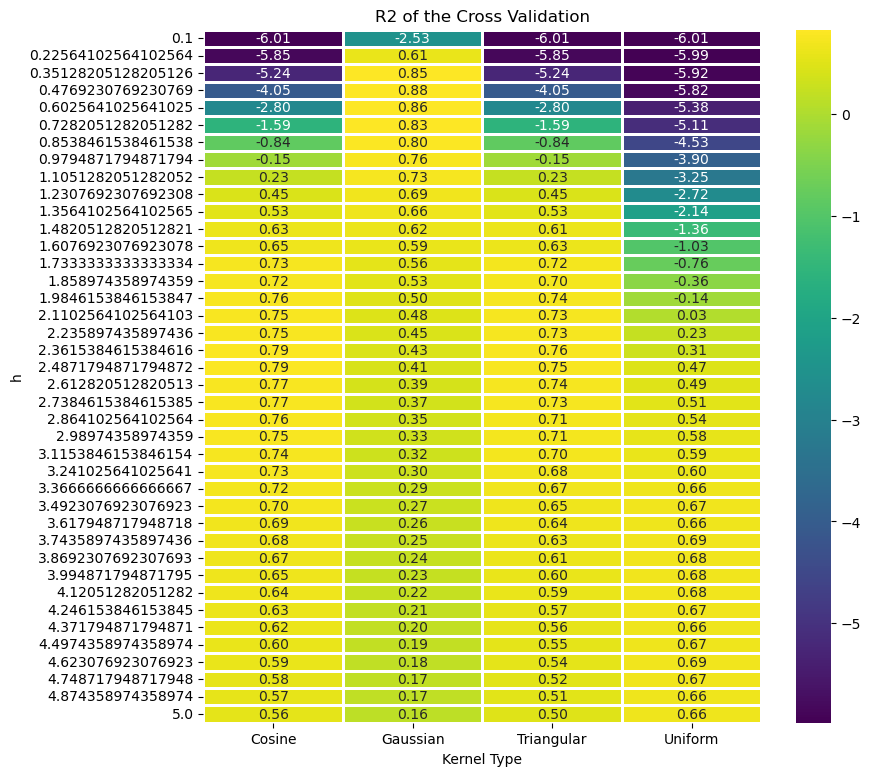

In [20]:
# Plotting the Train Data F1 as a Heat Map
# We can pivot the data set created to have a 2D matrix of the score as a function of parameters.

hF, hA = plt.subplots(figsize = (9, 9))

# hA = sns.heatmap(data = dfModelScore.pivot(index = 'h', columns = 'Kernel Type', values = 'R2'), robust = True, linewidths = 1, annot = True, fmt = '0.2f', norm = LogNorm(), ax = hA)
hA = sns.heatmap(data = dfModelScore.pivot(index = 'h', columns = 'Kernel Type', values = 'R2'), robust = True, linewidths = 1, annot = True, fmt = '0.2f', cmap = 'viridis', ax = hA)
hA.set_title('R2 of the Cross Validation')
plt.show()

* <font color='red'>(**?**)</font> What's the actual model in production for Kernel Regression?
* <font color='brown'>(**#**)</font> In production we'd extract the best hyper parameters and then train again on the whole data.
* <font color='brown'>(**#**)</font> Usually, for best hyper parameters, it is better to use cross validation with low number of folds.  
Using Leave One Out is better for estimating real world performance. The logic is that the best hyper parameters should be selected when they are tested with low correlation of the data.

### Regression Results

Results of the best model.

In [22]:
# Optimal Model

# Extract best model Hyper Parameters
bestModelIdx    = dfModelScore['R2'].idxmax()
kernelType      = dfModelScore.loc[bestModelIdx, 'Kernel Type']
paramH          = dfModelScore.loc[bestModelIdx, 'h']

# Construct & Train best model
oKerReg = KernelRegressor(kernelType = kernelType, paramH = paramH)
oKerReg = oKerReg.fit(mX, vY)


Text(0, 0.5, 'Predicted Price [1000$]')

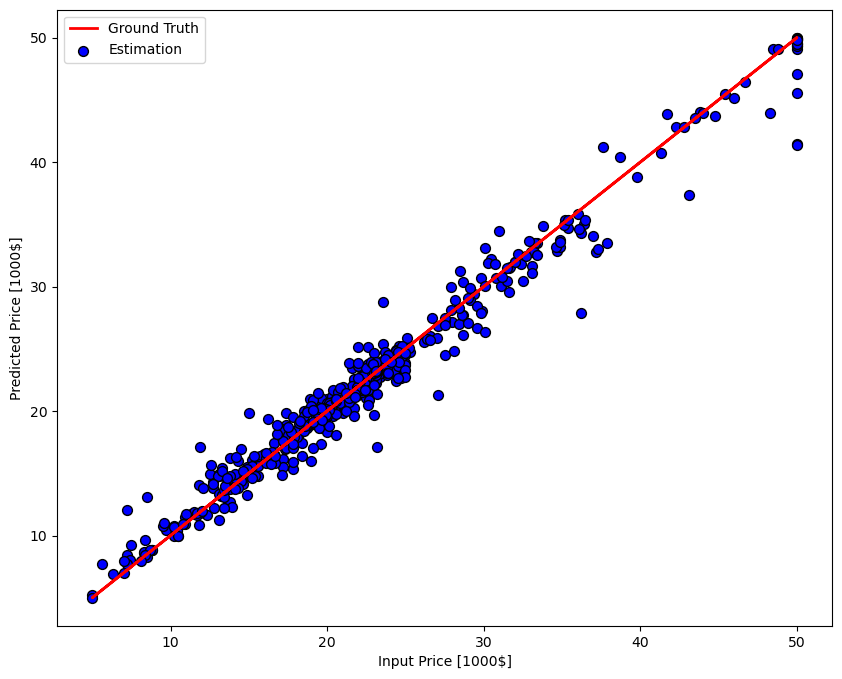

In [23]:
# Plot Regression Results

hF, hA = plt.subplots(figsize = (10, 8))
hA = PlotRegressionResults(vY, oKerReg.predict(mX), hA = hA)
hA.set_xlabel('Input Price [1000$]')
hA.set_ylabel('Predicted Price [1000$]')

### Vectorized Cross Validation for Kernel Regression

One way to optimize the process is by pre calculating the distance matrix for the whole data.  
Then using a sub set of it according to the subset for training.

For instance, let's recreate the _Leave One Out_:

1. Calculate the Distance Matrix $\boldsymbol{D}_{x} \in \mathbb{R}^{N \times N}$ such that $ \boldsymbol{D}_{x} \left[ i, j \right] = \left\| \boldsymbol{x}_{i}-\boldsymbol{x}_{j} \right\| _{2}$.
2. Calculate the weights matrix $\boldsymbol{W} \in \mathbb{R}^{N \times N}$ such that $\boldsymbol{W} \left[ i, j \right] = k \left( \frac{1}{h} \boldsymbol{D}_{x} \left[ i, j \right] \right)$.
3. Estimate $\boldsymbol{x}_{i}$ without using $\boldsymbol{x}_{i}$ we set $\boldsymbol{W} \left[ i, i \right] = 0$.
4. Apply kernel regression $\hat{\boldsymbol{y}} = \left( \boldsymbol{W} \boldsymbol{y} \right) \oslash \left( \boldsymbol{W} \boldsymbol{1} \right)$. Where $\oslash$ is element wise division.

In [21]:
# Vectorized Leave One Out Kernel Regression

numSamples = len(vY) #<! Number of Samples
hK = GaussianKernel #<! Kernel
paramH = 0.3 #<! Bandwidth
mD = sp.spatial.distance.cdist(mX, mX, metric = 'euclidean') #<! Distance Matrix
mW = hK(mD / paramH) #<! Weights matrix

# Zeroing the diagonal to prevent the weight of the sample
mW[range(numSamples), range(numSamples)] = 0 #<! Leave One Out
vYPred = (mW @ vY) / np.sum(mW, axis = 1) #<! Kernel Regression

print(f'The Leave One Out R2 Score for Kernel Type = {hK} and Bandwidth = {paramH} is {r2_score(vY, vYPred) }.')


The Leave One Out R2 Score for Kernel Type = <function GaussianKernel at 0x7fa46e8e8220> and Bandwidth = 0.3 is 0.8861968191595648.


* <font color='green'>(**@**)</font> Plot the regression of the best model (See previous notebooks).